In [1]:
import h5py
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import itertools 
import pyts
from pyts.approximation import PiecewiseAggregateApproximation

from sklearn.utils import class_weight

import pathlib
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, optimizers
from tensorflow.keras.layers import Convolution2D,Conv2D, Dense,Dropout, Flatten, Activation, MaxPooling2D, Input, Conv1D, GlobalAveragePooling1D, TimeDistributed, GRU, LSTM

print(tf.__version__)
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
gpus = tf.config.experimental.list_physical_devices('GPU')

try:
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)
except RuntimeError as e:
    print(e)

2021-12-03 14:11:22.735499: I tensorflow/stream_executor/platform/default/dso_loader.cc:54] Successfully opened dynamic library libcudart.so.11.0


2.5.0
Num GPUs Available:  1


2021-12-03 14:11:23.536561: I tensorflow/stream_executor/platform/default/dso_loader.cc:54] Successfully opened dynamic library libcuda.so.1
2021-12-03 14:11:23.579335: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1734] Found device 0 with properties: 
pciBusID: 0000:21:00.0 name: NVIDIA GeForce RTX 2080 Ti computeCapability: 7.5
coreClock: 1.545GHz coreCount: 68 deviceMemorySize: 10.76GiB deviceMemoryBandwidth: 573.69GiB/s
2021-12-03 14:11:23.579380: I tensorflow/stream_executor/platform/default/dso_loader.cc:54] Successfully opened dynamic library libcudart.so.11.0
2021-12-03 14:11:23.582836: I tensorflow/stream_executor/platform/default/dso_loader.cc:54] Successfully opened dynamic library libcublas.so.11
2021-12-03 14:11:23.582896: I tensorflow/stream_executor/platform/default/dso_loader.cc:54] Successfully opened dynamic library libcublasLt.so.11
2021-12-03 14:11:23.584460: I tensorflow/stream_executor/platform/default/dso_loader.cc:54] Successfully opened dynamic library li

In [18]:
def plot_confusion_matrix_norm(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):

    """

    This function prints and plots the confusion matrix.

    Normalization can be applied by setting `normalize=True`.

    """

    plt.figure(figsize=(10,10))



    

    plt.title(title)



    tick_marks = np.arange(len(classes))

    plt.xticks(tick_marks, classes, rotation=45)

    plt.yticks(tick_marks, classes)



    if normalize:

        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

        cm = np.around(cm, decimals=2)

        cm[np.isnan(cm)] = 0.0

        print("Normalized confusion matrix")

    else:

        print('Confusion matrix, without normalization')

    thresh = cm.max() / 2.

    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):

        plt.text(j, i, cm[i, j],

                 horizontalalignment="center",

                 color="white" if cm[i, j] > thresh else "black")

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.tight_layout()

    plt.ylabel('True label')

    plt.xlabel('Predicted label')
    plt.colorbar()
    #plt.savefig(("out/B"+dataset.split("_")[0]+"TL"+datasetTL+seed),dpi=300)

In [3]:
def LSTM_3D(X_train, num_classes, lr = 0.0001):

    input_a = Input(shape = X_train.shape[1: ])

    x = TimeDistributed(Convolution2D(16, (7, 7), activation='relu', padding='same'))(input_a) 
    x = TimeDistributed(Convolution2D(16, (7, 7), activation='relu', padding='same'))(x)
    x = TimeDistributed(MaxPooling2D(pool_size=(2, 2), padding='same'))(x)
    x = TimeDistributed(Convolution2D(16, (3, 3), activation='relu', padding='same'))(x)
    x = TimeDistributed(Convolution2D(16, (3, 3), activation='relu', padding='same'))(x)
    x = TimeDistributed(MaxPooling2D(pool_size=(2, 2), padding='same'))(x)
    x = TimeDistributed(Convolution2D(16, (3, 3), activation='relu', padding='same'))(x)
    x = TimeDistributed(Convolution2D(16, (3, 3), activation='relu', padding='same'))(x)
    x = TimeDistributed(MaxPooling2D(pool_size=(2, 2), padding='same'))(x)
    x = Dropout(0.10)(x)

    out = TimeDistributed(Convolution2D(16, (3, 3), activation='relu', padding='same'))(x)
    out = TimeDistributed(Convolution2D(16, (3, 3), activation='relu', padding='same'))(out)
        # out = TimeDistributed(MaxPooling2D(pool_size=(2, 2), padding='same'))(out)
        # out = Dropout(0.60)(out)
    out = TimeDistributed(Flatten())(out)
    out = LSTM(16, return_sequences=False, unroll=False, dropout=0.2)(out)  # dropout=0.6 #return sequences = True
    prediction = Dense(num_classes, activation='softmax')(out)

    model = keras.models.Model(inputs=input_a, outputs=prediction)
    adam = optimizers.Adam(lr = lr)
    model.compile(loss = 'categorical_crossentropy', optimizer = adam, metrics = ['accuracy'])

    return model

In [4]:
def LSTM_3D_V56(X_train, num_classes, lr = 0.0001):
    
    input_a = Input(shape = X_train.shape[1: ])

    x = TimeDistributed(Convolution2D(32, (7, 7), activation='relu', padding='same'))(input_a)
    x = TimeDistributed(Convolution2D(32, (7, 7), activation='relu', padding='same'))(x)
    x = TimeDistributed(MaxPooling2D(pool_size=(2, 2), padding='same'))(x)
    
    x = TimeDistributed(Convolution2D(16, (3, 3), activation='relu', padding='same'))(x)
    x = TimeDistributed(Convolution2D(16, (3, 3), activation='relu', padding='same'))(x)
    x = TimeDistributed(MaxPooling2D(pool_size=(2, 2), padding='same'))(x)
    x = TimeDistributed(Convolution2D(8, (3, 3), activation='relu', padding='same'))(x)
    x = TimeDistributed(Convolution2D(8, (3, 3), activation='relu', padding='same'))(x)
    x = TimeDistributed(MaxPooling2D(pool_size=(2, 2), padding='same'))(x)
    x = Dropout(0.10)(x)

    x = TimeDistributed(Convolution2D(32, (7, 7), activation='relu', padding='same'))(x)
    x = TimeDistributed(Convolution2D(32, (7, 7), activation='relu', padding='same'))(x)
    x = TimeDistributed(MaxPooling2D(pool_size=(2, 2), padding='same'))(x)
    #out = Dropout(0.10)(out)
    x = TimeDistributed(Flatten())(x)
    x = LSTM(32, return_sequences=True, unroll=False, dropout=0.1)(x)  # dropout=0.6
    out = LSTM(32, return_sequences=False, unroll=False, dropout=0.1)(x)
    
    prediction = Dense(num_classes, activation='softmax')(out)
    model = keras.models.Model(inputs=input_a, outputs=prediction)
    adam = optimizers.Adam(learning_rate = lr)
    model.compile(loss = 'categorical_crossentropy', optimizer = adam, metrics = ['accuracy'])

    return model

In [5]:
def basic_cnn_functional(X_train, num_classes, lr = 0.0001):
    
    input_a = Input(shape = X_train.shape[1: ])
    
    x = Convolution2D(16, (7, 7), activation='relu', padding='same')(input_a)
    x = Convolution2D(16, (7, 7), activation='relu', padding='same')(x)
    x = MaxPooling2D(pool_size=(2, 2), padding='same')(x)
    x = Convolution2D(16, (3, 3), activation='relu', padding='same')(x)
    x = Convolution2D(16, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D(pool_size=(2, 2), padding='same')(x)
    x = Convolution2D(16, (3, 3), activation='relu', padding='same')(x)
    x = Convolution2D(16, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D(pool_size=(2, 2), padding='same')(x)
    x = Dropout(0.10)(x)

    out = Convolution2D(16, (3, 3), activation='relu', padding='same')(x)
    out = Convolution2D(16, (3, 3), activation='relu', padding='same')(out)
        # out = TimeDistributed(MaxPooling2D(pool_size=(2, 2), padding='same'))(out)
        # out = Dropout(0.60)(out)
    out = Flatten()(out)
    # dense layer with 50 neurons
    dense = Dense(64, activation = 'relu')(out)
    # final layer with 10 neurons to classify the instances
    output = Dense(num_classes, activation = 'softmax')(dense)
    
    adam = optimizers.Adam(lr = lr)
    model = keras.models.Model(inputs=input_a, outputs=output)
    model.compile(loss = 'categorical_crossentropy', optimizer = adam, metrics = ['accuracy'])
    
    return model

In [6]:
#LOAD DATASET
#file_name = "ukdale_gen_GASF_13m_100S5X12A54480"
#file_name = "refit_gen_GASF_13m_100S5X_15A166006"
file_name = "refit_gen_GASF_13m_100S5X_15A166006_R42-80-20"
file_name = "refit_gen_GASF_13m_100S5X_15A166006_R82_80-20"
#read the file
path = str(pathlib.Path().resolve())

path_data = f"{path}""/data/"f"{file_name}""/"f"{file_name}"".hdf5"

file = h5py.File(path_data,"r+")

In [7]:
path

'/workspace/notebooks'

In [8]:
train = file["data/train/gaf"][0:10]

In [9]:
train.shape[1:]

(5, 100, 100, 1)

In [6]:
#fetch array of appliances
def get_data():
    enc_appliances = np.array(file["appliances/classes"])
    appliances = [n.decode("utf-8") for n in enc_appliances]
    num_of_classes = file["appliances/classes"].shape[0]
    
    print(appliances)

    x_test = np.array(file['data/test']['gaf'])
    #x_test = 0
    y_test = np.array(file['labels/test']['gaf'])
    y_train = file["labels/train/gaf"][:]
    class_weights = class_weight.compute_class_weight(class_weight="balanced", classes = np.unique(y_train), y=y_train)
    d_class_weights = dict(enumerate(class_weights))
    print(d_class_weights)
    
    print(" ")
    print("Tests ")
    for ctest,ctrain,appl in zip(np.unique(y_test,return_counts=True)[1],np.unique(y_train,return_counts=True)[1],appliances):
        print(appl,"test:",ctest,"train:",ctrain)
    
    y_test = tf.keras.utils.to_categorical(y_test, num_classes=num_of_classes)
    
    return x_test,y_test,d_class_weights,num_of_classes,appliances

In [7]:
def evaluate_model(model_used):
    #Print results and plot confusion matrix

    Y_pred = model_used.predict(x_test, verbose = 2)
    y_pred = np.argmax(Y_pred, axis=1)
    Y_test = np.argmax(y_test, axis=-1)
    C = confusion_matrix(Y_test, y_pred)
    print(confusion_matrix(Y_test, y_pred))
    #recision,recall,fscore,support=score(Y_test, y_pred,average='macro')
    #print("F1 SCORE",fscore)
    plot_confusion_matrix_norm(C, appliances, normalize=True)
    print(classification_report(Y_test, y_pred, target_names=appliances))

In [8]:
def create_tl_model(model):
    print("compling TL model..")
    #create TL model 
    path_model = path+"/models/LAST/"+model
    #path_model = path+"/models/refit/GSAF/LSTM3DV56/model2"

    model = keras.models.load_model(path_model)
    #create trasfer learning model 
    model.trainable = False
    base_output = model.layers[-2].output
    hidden4 = Dense(64, activation='relu')(base_output)
    hidden3 = Dense(32, activation='relu')(hidden4)
    hidden2 = Dense(16, activation='relu')(hidden3)
    hidden = Dense(num_of_classes, activation='softmax')(hidden2)

    model2 = keras.models.Model(model.inputs, hidden)
    lr = 0.002
    adam = optimizers.Adam(lr = lr)
    model2.compile(loss = 'categorical_crossentropy', optimizer = adam, metrics = ['accuracy'])
    return model2

In [15]:
#train test split
print("...spliting")

print("loading labels")
Y = file["labels/gaf"][:]
print("loading images")
X =  file["data/gaf"]

x_ids = list(range(len(X)))

x_train_ids, x_test_ids = train_test_split(x_ids,test_size=0.2,random_state=12,stratify=Y)
print("split shapes shapes:")
print(len(x_train_ids))
print(len(x_test_ids))

...spliting
loading labels
loading images
split shapes shapes:
132804
33202


In [13]:
x_test,y_test,d_class_weights,num_of_classes,appliances = get_data()

['HEKA', 'fridge/freezer', 'audio system', 'breadmaker', 'broadband router', 'computer', 'dehumidifier', 'dish washer', 'electric space heater', 'food processor', 'pond pump', 'television', 'tumble dryer', 'washer dryer', 'washing machine']
{0: 0.3663356504468719, 1: 0.22525951557093427, 2: 6.4672023374726075, 3: 34.85669291338583, 4: 4.910482529118137, 5: 0.43032954214056574, 6: 18.068571428571428, 7: 2.8259176508139165, 8: 11.852208835341365, 9: 12.611965811965812, 10: 2.7789077212806026, 11: 0.2799203262828417, 12: 7.359600997506234, 13: 38.32727272727273, 14: 2.2073298429319372}
 
Tests 
HEKA test: 6042 train: 24168
fridge/freezer test: 9826 train: 39304
audio system test: 342 train: 1369
breadmaker test: 64 train: 254
broadband router test: 451 train: 1803
computer test: 5143 train: 20574
dehumidifier test: 123 train: 490
dish washer test: 783 train: 3133
electric space heater test: 187 train: 747
food processor test: 175 train: 702
pond pump test: 796 train: 3186
television test:

In [14]:
#read the file

train_gen = HDF5ImageGenerator(
    src= path_data,
    X_key="data/train/gaf",
    y_key="labels/train/gaf",
    classes_key="appliances/classes",
    labels_encoding="hot",
    shuffle=True,
    batch_size=64,
    num_classes=num_of_classes,
    mode="train",
    )

# test_gen = HDF5ImageGenerator(
#    src= path_data,
#    scaler=False,
#    X_key="data/test/gaf",
#    y_key="labels/test/gaf",
#    classes_key="classes/appliances",
#    labels_encoding="hot",
#    shuffle=False,
#    batch_size=32,
#    num_classes=num_of_classes,
#    mode="test"
#    )

Normal way
[0 1 2 3 4 5 6 7 8 9]


In [15]:
model = LSTM_3D_V56(file["data/train/gaf"][0:10],num_of_classes,lr= 0.00002)

model.fit(
    train_gen,
    verbose=1,
    epochs=150,
    class_weight=d_class_weights,

)


2021-12-02 07:49:51.475279: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1734] Found device 0 with properties: 
pciBusID: 0000:21:00.0 name: NVIDIA GeForce RTX 2080 Ti computeCapability: 7.5
coreClock: 1.545GHz coreCount: 68 deviceMemorySize: 10.76GiB deviceMemoryBandwidth: 573.69GiB/s
2021-12-02 07:49:51.478697: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1872] Adding visible gpu devices: 0
2021-12-02 07:49:51.479080: I tensorflow/stream_executor/platform/default/dso_loader.cc:54] Successfully opened dynamic library libcudart.so.11.0
2021-12-02 07:49:52.365753: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1258] Device interconnect StreamExecutor with strength 1 edge matrix:
2021-12-02 07:49:52.365815: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1264]      0 
2021-12-02 07:49:52.366039: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1277] 0:   N 
2021-12-02 07:49:52.366620: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1418] Created TensorFlow device 

Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.
Epoch 1/150


2021-12-02 07:49:52.876714: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2021-12-02 07:49:52.896557: I tensorflow/core/platform/profile_utils/cpu_utils.cc:114] CPU Frequency: 3299990000 Hz
2021-12-02 07:49:54.897478: I tensorflow/stream_executor/platform/default/dso_loader.cc:54] Successfully opened dynamic library libcudnn.so.8
2021-12-02 07:49:55.637308: I tensorflow/stream_executor/cuda/cuda_dnn.cc:380] Loaded cuDNN version 8202
2021-12-02 07:49:56.483963: I tensorflow/stream_executor/platform/default/dso_loader.cc:54] Successfully opened dynamic library libcublas.so.11
2021-12-02 07:49:57.246840: I tensorflow/stream_executor/platform/default/dso_loader.cc:54] Successfully opened dynamic library libcublasLt.so.11


2076/2076 [==============================] - 223s 105ms/step - loss: 2.4300 - accuracy: 0.2787
True
Epoch 2/150
2076/2076 [==============================] - 216s 104ms/step - loss: 1.9732 - accuracy: 0.4557
True
Epoch 3/150
2076/2076 [==============================] - 216s 104ms/step - loss: 1.6590 - accuracy: 0.5141
True
Epoch 4/150
2076/2076 [==============================] - 216s 104ms/step - loss: 1.4297 - accuracy: 0.5496
True
Epoch 5/150
2076/2076 [==============================] - 216s 104ms/step - loss: 1.2548 - accuracy: 0.5745
True
Epoch 6/150
2076/2076 [==============================] - 216s 104ms/step - loss: 1.1186 - accuracy: 0.5919
True
Epoch 7/150
2076/2076 [==============================] - 216s 104ms/step - loss: 1.0169 - accuracy: 0.6077
True
Epoch 8/150
2076/2076 [==============================] - 216s 104ms/step - loss: 0.9375 - accuracy: 0.6252
True
Epoch 9/150
2076/2076 [==============================] - 216s 104ms/step - loss: 0.8690 - accuracy: 0.6430
True
Epoc

2076/2076 [==============================] - 216s 104ms/step - loss: 0.2656 - accuracy: 0.8463
True
Epoch 74/150
2076/2076 [==============================] - 216s 104ms/step - loss: 0.2665 - accuracy: 0.8480
True
Epoch 75/150
2076/2076 [==============================] - 216s 104ms/step - loss: 0.2619 - accuracy: 0.8461
True
Epoch 76/150
2076/2076 [==============================] - 216s 104ms/step - loss: 0.2610 - accuracy: 0.8500
True
Epoch 77/150
2076/2076 [==============================] - 216s 104ms/step - loss: 0.2572 - accuracy: 0.8498
True
Epoch 78/150
2076/2076 [==============================] - 216s 104ms/step - loss: 0.2544 - accuracy: 0.8502
True
Epoch 79/150
2076/2076 [==============================] - 216s 104ms/step - loss: 0.2541 - accuracy: 0.8504
True
Epoch 80/150
2076/2076 [==============================] - 216s 104ms/step - loss: 0.2494 - accuracy: 0.8513
True
Epoch 81/150
2076/2076 [==============================] - 216s 104ms/step - loss: 0.2461 - accuracy: 0.8528
T

2076/2076 [==============================] - 216s 104ms/step - loss: 0.1572 - accuracy: 0.8911
True
Epoch 146/150
2076/2076 [==============================] - 216s 104ms/step - loss: 0.1606 - accuracy: 0.8901
True
Epoch 147/150
2076/2076 [==============================] - 216s 104ms/step - loss: 0.1614 - accuracy: 0.8907
True
Epoch 148/150
2076/2076 [==============================] - 216s 104ms/step - loss: 0.1613 - accuracy: 0.8922
True
Epoch 149/150
2076/2076 [==============================] - 216s 104ms/step - loss: 0.1561 - accuracy: 0.8915
True
Epoch 150/150
2076/2076 [==============================] - 216s 104ms/step - loss: 0.1585 - accuracy: 0.8924
True


In [25]:
#path_model1 = path+"/models/LAST/ukdale"
#model.save(path_model1)

In [26]:
model = keras.models.load_model(path_model1)
model_used = model

2021-11-30 17:42:13.998026: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1734] Found device 0 with properties: 
pciBusID: 0000:21:00.0 name: NVIDIA GeForce RTX 2080 Ti computeCapability: 7.5
coreClock: 1.545GHz coreCount: 68 deviceMemorySize: 10.76GiB deviceMemoryBandwidth: 573.69GiB/s
2021-11-30 17:42:13.998787: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1872] Adding visible gpu devices: 0
2021-11-30 17:42:13.998866: I tensorflow/stream_executor/platform/default/dso_loader.cc:54] Successfully opened dynamic library libcudart.so.11.0
2021-11-30 17:42:14.694011: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1258] Device interconnect StreamExecutor with strength 1 edge matrix:
2021-11-30 17:42:14.694044: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1264]      0 
2021-11-30 17:42:14.694051: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1277] 0:   N 
2021-11-30 17:42:14.694661: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1418] Created TensorFlow device 

341/341 - 5s
[[1635    2    0    0    0    0    0    1  321    0    0    0]
 [   0 1462    1   11   17    1    0    0    0    2    5    0]
 [   0    0  564    0   18    9    1    0    0    1    7    0]
 [   0    8    0  700    4    0    0    0    0    2    1    0]
 [   0    3   22    2  777   21    4    0    0    1    4    1]
 [   0    0    5    0    1  646    5    3    0    5    4    0]
 [   0    0    1    2    7   15  949    1    0    0    6    0]
 [   0    2    0    0    0    9    1  585    0    0    3    0]
 [  61    0    0    1    0    0    1    0  983    0    0    0]
 [   0    0    0    0    0    6    0    0    0  389    1    1]
 [   0    6    8    3   39    4    5    3    1    4  964    4]
 [   0    0    0    0    0    0    0    2    0    0   15  537]]
Normalized confusion matrix
                  precision    recall  f1-score   support

            HEKA       0.96      0.83      0.89      1959
  fridge/freezer       0.99      0.98      0.98      1499
            HTPC       0.94

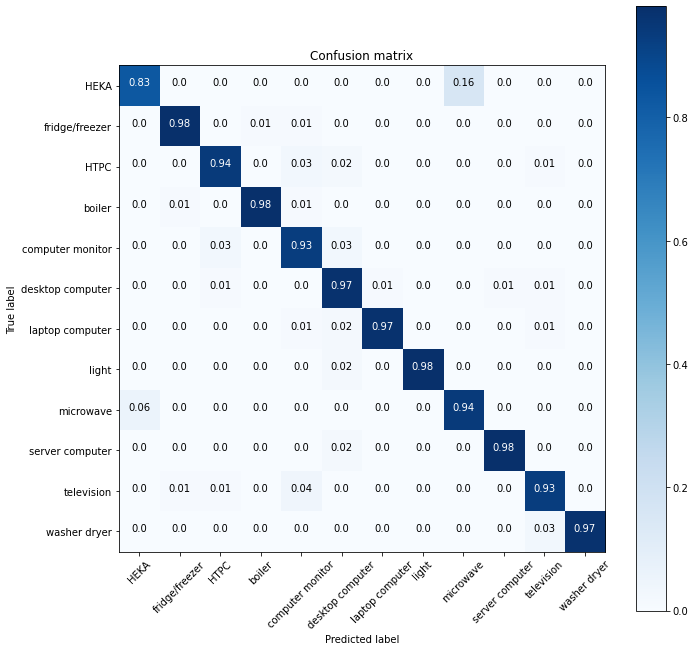

In [19]:

evaluate_model(model_used)
        

In [20]:
file_name

'refit_gen_GASF_13m_100S5X_15A166006_R82_80-20'

using dataset data ukdale training on model ['base'] seed 80-20
reading data, printing stats: 
['HEKA', 'fridge/freezer', 'HTPC', 'boiler', 'computer monitor', 'desktop computer', 'laptop computer', 'light', 'microwave', 'server computer', 'television', 'washer dryer']
{0: 0.46362011743681386, 1: 0.6056361514090378, 2: 1.5133333333333334, 3: 1.2690426275331936, 4: 1.0880766926303176, 5: 1.3567426223384385, 6: 0.9253503184713375, 7: 1.5133333333333334, 8: 0.8680688336520076, 9: 2.2857142857142856, 10: 0.8724477540235407, 11: 1.6397291196388262}
 
Tests 
HEKA test: 1959 train: 7834
fridge/freezer test: 1499 train: 5997
HTPC test: 600 train: 2400
boiler test: 715 train: 2862
computer monitor test: 835 train: 3338
desktop computer test: 669 train: 2677
laptop computer test: 981 train: 3925
light test: 600 train: 2400
microwave test: 1046 train: 4184
server computer test: 397 train: 1589
television test: 1041 train: 4163
washer dryer test: 554 train: 2215
loading model
Normal way
[0 1 2 3 4

681/681 [==============================] - 71s 104ms/step - loss: 0.1994 - accuracy: 0.9220
True
Epoch 67/150
681/681 [==============================] - 71s 104ms/step - loss: 0.1950 - accuracy: 0.9231
True
Epoch 68/150
681/681 [==============================] - 71s 104ms/step - loss: 0.1936 - accuracy: 0.9240
True
Epoch 69/150
681/681 [==============================] - 71s 104ms/step - loss: 0.1892 - accuracy: 0.9261
True
Epoch 70/150
681/681 [==============================] - 71s 104ms/step - loss: 0.1892 - accuracy: 0.9277
True
Epoch 71/150
681/681 [==============================] - 71s 104ms/step - loss: 0.1866 - accuracy: 0.9254
True
Epoch 72/150
681/681 [==============================] - 71s 104ms/step - loss: 0.1862 - accuracy: 0.9263
True
Epoch 73/150
681/681 [==============================] - 71s 104ms/step - loss: 0.1849 - accuracy: 0.9259
True
Epoch 74/150
681/681 [==============================] - 71s 104ms/step - loss: 0.1827 - accuracy: 0.9262
True
Epoch 75/150
681/681 [=

681/681 [==============================] - 71s 104ms/step - loss: 0.1128 - accuracy: 0.9486
True
Epoch 141/150
681/681 [==============================] - 71s 104ms/step - loss: 0.1110 - accuracy: 0.9499
True
Epoch 142/150
681/681 [==============================] - 71s 104ms/step - loss: 0.1119 - accuracy: 0.9481
True
Epoch 143/150
681/681 [==============================] - 71s 104ms/step - loss: 0.1080 - accuracy: 0.9494
True
Epoch 144/150
681/681 [==============================] - 71s 104ms/step - loss: 0.1111 - accuracy: 0.9487
True
Epoch 145/150
681/681 [==============================] - 71s 104ms/step - loss: 0.1094 - accuracy: 0.9497
True
Epoch 146/150
681/681 [==============================] - 71s 104ms/step - loss: 0.1064 - accuracy: 0.9505
True
Epoch 147/150
681/681 [==============================] - 71s 104ms/step - loss: 0.1063 - accuracy: 0.9505
True
Epoch 148/150
681/681 [==============================] - 71s 104ms/step - loss: 0.1064 - accuracy: 0.9514
True
Epoch 149/150
6

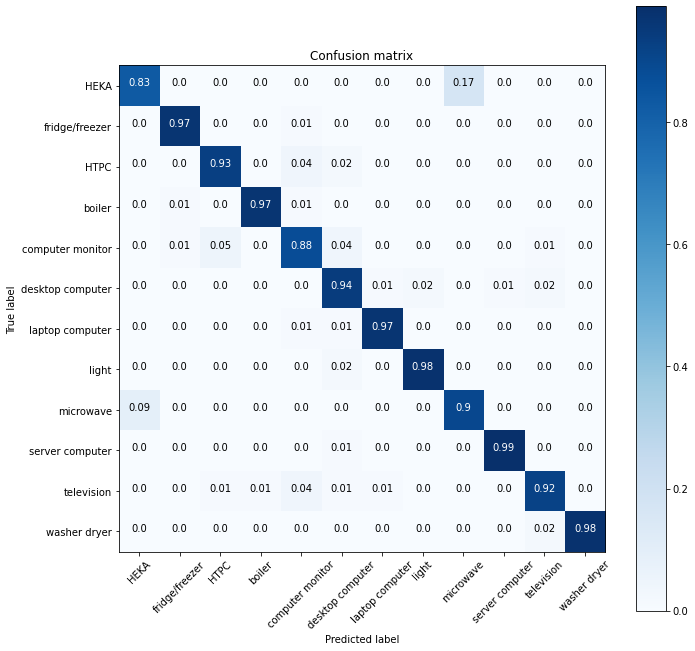

In [20]:


datasets =[
    "ukdale_gen_GASF_13m_100S5X12A54480_R82_80-20"
]

#models =["ukdale","eco","redd","iawe"]
model = ["base"]
#for model in models:
for dataset in datasets:
    file_name = dataset
    names = dataset.split("_")
    datasetTL = model
    seed = names[6]
    print("using dataset data",names[0],"training on model",model,"seed",seed)
    tf.keras.backend.clear_session()


    #read the file
    path = str(pathlib.Path().resolve())
    path_data = f"{path}""/data/"f"{file_name}""/"f"{file_name}"".hdf5"
    file = h5py.File(path_data,"r+")


    print("reading data, printing stats: ")
    x_test,y_test,d_class_weights,num_of_classes,appliances = get_data()
    print("loading model")
    #model_used = create_tl_model(model)
    model_used  = LSTM_3D_V56(file["data/train/gaf"][0:10],num_of_classes,lr= 0.00002)
    train_gen = HDF5ImageGenerator(
        src= path_data,
        X_key="data/train/gaf",
        y_key="labels/train/gaf",
        classes_key="appliances/classes",
        labels_encoding="hot",
        shuffle=True,
        batch_size=64,
        num_classes=num_of_classes,
        mode="train",
        )

    model_used.fit(
        train_gen,
        verbose=1,
        epochs=150,
        class_weight=d_class_weights,
        #workers = 6,
    )
    evaluate_model(model_used)



    #del model_used



In [10]:
#run me!
from typing import Tuple, Union, Optional

import h5py as h5
from tensorflow.keras.utils import Sequence
from tensorflow.keras.utils import to_categorical

#from albumentations import Compose
import numpy as np

available_modes = {"train", "test"}
available_labels_encoding = {"hot", "smooth", False}

def my_print(s):
    print(s)
    with open('log.log', 'a') as f:
        f.write(str(s) + '\n')

class HDF5ImageGenerator(keras.utils.Sequence):
    """Just a simple custom Keras HDF5 ImageDataGenerator.
    
    Custom Keras ImageDataGenerator that generates
    batches of tensor images from HDF5 files with (optional) real-time
    data augmentation.
     
    Arguments
    ---------
    src : str
        Path of the hdf5 source file.
    X_key : str
        Key of the h5 file image tensors dataset.
        Default is "images".
    y_key : str
        Key of the h5 file labels dataset.
        Default is "labels".
    classes_key : str
        Key of the h5 file dataset containing
        the raw classes.
        Default is None.
    batch_size : int
        Size of each batch, must be a power of two.
        (16, 32, 64, 128, 256, ...)
        Default is 32.
    shuffle : bool
        Shuffle images at the end of each epoch.
        Default is True.
    scaler : "std", "norm" or False
        "std" mode means standardization to range [-1, 1]
        with 0 mean and unit variance.
        "norm" mode means normalization to range [0, 1].
        Default is "std".
    num_classes : None or int
        Specifies the total number of classes
        for labels encoding.
        Default is None.
    labels_encoding : "hot", "smooth" or False
        "hot" mode means classic one hot encoding.
        "smooth" mode means smooth hot encoding.
        Default is "hot".
    smooth_factor : int or float
        smooth factor used by smooth
        labels encoding.
        Default is 0.1.
    augmenter : albumentations Compose([]) Pipeline or False
        An albumentations transformations pipeline
        to apply to each sample.
        Default is False.
    mode : str "train" or "test"
        Model generator type. "train" is used for
        fit_generator() and evaluate_generator.
        "test" is used for predict_generator().
        Default is "train".
        
    Notes
    -----
    Turn off scaler (scaler=False) if using the
    ToFloat(max_value=255) transformation from
    albumentations.
        
    Examples
    --------
    Example of usage:
    ```python
    my_augmenter = Compose([
        HorizontalFlip(p=0.5),
        RandomContrast(limit=0.2, p=0.5),
        RandomGamma(gamma_limit=(80, 120), p=0.5),
        RandomBrightness(limit=0.2, p=0.5),
        Resize(227, 227, cv2.INTER_AREA)
    ])
    # Create the generator.
    train_gen = HDF5ImageGenerator(
        'path/to/my/file.h5',
         augmenter=my_augmenter)
    ```
    """
    def __init__(
        self,
        src,
        indices_sel = [], #incides are already used by this lib
        X_key="data/gasf",
        y_key="labels/gaf",
        classes_key="classes/appliances",
        batch_size=8,
        shuffle=False,
        scaler=False,
        num_classes=9,
        labels_encoding="hot",
        smooth_factor=0.1,
        augmenter=False,
        mode="train",
    ):

        if mode not in available_modes:
            raise ValueError('`mode` should be `train` '
                             '(fit_generator() and evaluate_generator()) or '
                             '`test` (predict_generator(). '
                             'Received: %s' % mode)
        self.mode = mode

        if labels_encoding not in available_labels_encoding:
            raise ValueError('`labels_encoding` should be `hot` '
                             '(classic binary matrix) or '
                             '`smooth` (smooth encoding) or '
                             'False (no labels encoding). '
                             'Received: %s' % labels_encoding)
        self.labels_encoding = labels_encoding

        if (self.labels_encoding == "smooth") and not (0 < smooth_factor <= 1):
            raise ValueError('`smooth` labels encoding '
                             'must use a `smooth_factor` '
                             '< 0 smooth_factor <= 1')

        if augmenter and not isinstance(augmenter, Compose):
            raise ValueError('`augmenter` argument '
                             'must be an instance of albumentations '
                             '`Compose` class. '
                             'Received type: %s' % type(augmenter))
        self.augmenter = augmenter

        self.src: str = src
        self.X_key: str = X_key
        self.y_key: str = y_key
        self.classes_key: str = classes_key
        self.batch_size: int = batch_size
        self.shuffle: bool = shuffle
        self.scaler: bool = scaler
        self.num_classes: int = num_classes
        self.smooth_factor: float = smooth_factor
        
        
        
        if indices_sel:
            self._indices = np.array(x_train_ids)
            print("calculating shape beforehand...")
            self._parse_mode = "indices";
            self._ds_shape = file[self.y_key][np.sort(self._indices)].shape
        else:
            print("Normal way")
            self._parse_mode = "normal";
            self._indices = np.arange(self.__get_dataset_shape(self.X_key, 0))
        
        print(self._indices[:10])
        
       

    def __repr__(self):
        """Representation of the class."""
        return f"{self.__class__.__name__}({self.__dict__!r})"

    def __get_dataset_shape(self, dataset: str, index: int) -> Tuple[int, ...]:
        """Get an h5py dataset shape.
        
        Arguments
        ---------
        dataset : str
            The dataset key.
        index : int
            The dataset index.
         
        Returns
        -------
        tuple of ints
            A tuple of array dimensions.
        """
        with h5.File(self.src, "r", libver="latest", swmr=True) as file:
            #print("getting ds shape, current: ",self._ds_shape,"first time",self._first_time)
            #if self._first_time:
            #    print("calculating")
            #    self._ds_shape = file[self.y_key][np.sort(self._indices)].shape[index]
            #    self._first_time = 0
                
            #print("using dataset shape: ",self._ds_shape)   
            if self._parse_mode == "normal":
                #default way when no inndices defined
                return file[dataset].shape[index]
            else:
                #optimised way for indices
                return self._ds_shape[index]
            


    def __get_dataset_items(
        self,
        indices: np.ndarray,
        dataset: Optional[str] = None
    ) -> Union[np.ndarray, Tuple[np.ndarray, np.ndarray]]:
        """Get an HDF5 dataset items.
        
        Arguments
        ---------
        indices : ndarray, 
            The list of current batch indices.
        dataset : (optional) str
            The dataset key. If None, returns
            a batch of (image tensors, labels).
            Defaults to None.
         
        Returns
        -------
        np.ndarray or a tuple of ndarrays
            A batch of samples.
        """
        
        with h5.File(self.src, "r", libver="latest", swmr=True) as file:
            
            if dataset is not None:
                return file[dataset][indices]
            else:
                return (file[self.X_key][indices], file[self.y_key][indices])
    
    @property
    def num_items(self) -> int:
        """Grab the total number of examples
         from the dataset.
         
        Returns
        -------
        int
            The total number of examples.
        """
        with h5.File(self.src, "r") as file:
            return file[self.X_key].shape[0]
    
    @property 
    def classes(self) -> list:
        """Grab "human" classes from the dataset.
        
        Returns
        -------
        list
            A list of the raw classes.
        """
        if self.classes_key is None:
            raise ValueError('Canceled. parameter `classes_key` '
                             'is set to None.')
        
        with h5.File(self.src, "r") as file:
            return file[self.classes_key][:]

    def __len__(self):
        """Denotes the number of batches per epoch.
         
        Returns
        -------
        int
            The number of batches per epochs.
        """
        return int(
            np.ceil(
                self.__get_dataset_shape(self.X_key, 0) /
                float(self.batch_size)))

    @staticmethod
    def apply_labels_smoothing(batch_y: np.ndarray,
                               factor: float) -> np.ndarray:
        """Applies labels smoothing to the original
         labels binary matrix.
         
        Arguments
        ---------
        batch_y : np.ndarray
            Current batch integer labels.
        factor : float
            Smoothing factor.
        
        Returns
        -------
        np.ndarray
            A binary class matrix.
        """
        batch_y *= 1 - factor
        batch_y += factor / batch_y.shape[1]

        return batch_y

    def apply_labels_encoding(
            self,
            batch_y: np.ndarray,
            smooth_factor: Optional[float] = None) -> np.ndarray:
        """Converts a class vector (integers) to binary class matrix.
         See Keras to_categorical utils function.
         
        Arguments
        ---------
        batch_y : np.ndarray
            Current batch integer labels.
        smooth_factor : (optional) Float
            Smooth factor.
            Defaults to None.
        
        Returns
        -------
        np.ndarray
            A binary class matrix.
        """
        batch_y = to_categorical(batch_y, num_classes=self.num_classes)

        if smooth_factor is not None:
            batch_y = self.apply_labels_smoothing(batch_y,
                                                  factor=smooth_factor)

        return batch_y

    @staticmethod
    def apply_normalization(batch_X: np.ndarray) -> np.ndarray:
        """Normalize the pixel intensities. 
        
        Normalize the pixel intensities to the range [0, 1].
         
        Arguments
        ---------
        batch_X : np.ndarray
            Batch of image tensors to be normalized.
        
        Returns
        -------
        np.ndarray
            A batch of normalized image tensors.
        """
        return batch_X.astype("float32") / 255.0

    def __next_batch_test(self, indices: np.ndarray) -> np.ndarray:
        """Generates a batch of test data for the given indices.
        
        Arguments
        ---------
        index : int
            The index for the batch.
            
        Returns
        -------
        ndarray
            4D tensor (num_samples, height, width, depth).
        """
        # Grab corresponding images from the HDF5 source file.
        batch_X = self.__get_dataset_items(indices, self.X_key)

        # Shall we rescale features?
        if self.scaler:
            batch_X = self.apply_normalization(batch_X)

        return batch_X

    def __next_batch(self,
                     indices: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
        """Generates a batch of train/val data for the given indices.
        
        Arguments
        ---------
        index : int
            The index for the batch.
            
        Returns
        -------
        tuple of ndarrays
            A tuple containing a batch of image tensors
            and their associated labels.
        """
        # Grab samples (tensors, labels) HDF5 source file.
        (batch_X, batch_y) = self.__get_dataset_items(indices)

        # Shall we apply any data augmentation?
        if self.augmenter:
            batch_X = np.stack(
                [self.augmenter(image=x)["image"] for x in batch_X], axis=0)

        # Shall we rescale features?
        if self.scaler:
            batch_X = self.apply_normalization(batch_X)

        # Shall we apply labels encoding?
        if self.labels_encoding:
            batch_y = self.apply_labels_encoding(
                batch_y,
                smooth_factor=self.smooth_factor
                if self.labels_encoding == "smooth" else None,
            )

        return (batch_X, batch_y)

    def __getitem__(
            self,
            index: int) -> Union[np.ndarray, Tuple[np.ndarray, np.ndarray]]:
        """Generates a batch of data for the given index.
        
        Arguments
        ---------
        index : int
            The index for the current batch.
            
        Returns
        -------
        tuple of ndarrays or ndarray
            A tuple containing a batch of image tensors
            and their associated labels (train) or
            a tuple of image tensors (predict).
        """
        # Indices for the current batch.
        indices = np.sort(self._indices[index * self.batch_size:(index + 1) *  self.batch_size])

        if self.mode == "train":
            return self.__next_batch(indices)
        else:
            return self.__next_batch_test(indices)

    def __shuffle_indices(self):
        """If the shuffle parameter is set to True,
         dataset will be shuffled (in-place).
         (not available in test 'mode').
        """
        my_print(self.shuffle)
        if (self.mode == "train") and self.shuffle:
            #my_print(self._indices)
            np.random.shuffle(self._indices)
            #my_print(self.shuffle)
            #my_print(self._indices)

    def on_epoch_end(self):
        """Triggered once at the very beginning as well as 
         at the end of each epoch.
        """
        self.__shuffle_indices()